# Neural Networks: Image Classification

## Learning Objectives

- use `keras` to code up a neural network model to classify images
- explore regularization in neural networks, including adding dropout
- recognize the structure of convolutional neural networks (CNN)

In [1]:
# from sklearn.datasets import load_sample_images
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from keras.datasets import mnist

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD

In [2]:
def visualize_training_results(history):
    '''
    From https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    
    Input: keras history object (output from trained model)
    '''
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    fig.suptitle('Model Results')

    # summarize history for accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_ylabel('Accuracy')
    ax1.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_ylabel('Loss')
    ax2.legend(['train', 'test'], loc='upper left')
    
    plt.xlabel('Epoch')
    plt.show()

#### Explore Data

The classic MNIST digits data!

In [3]:
# Grabbing our data directly from keras
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


Label: 7


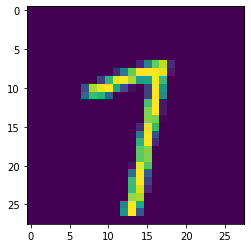

In [4]:
# Explore an example - can adjust the index number to explore
sample_index = 42

sample_image = X_train[sample_index]
sample_label = y_train[sample_index]
display(plt.imshow(sample_image))
print('Label: {}'.format(sample_label));

In [5]:
sample_image.shape

(28, 28)

In [6]:
sample_image

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

### Things to know:

- The data and labels in `fit()` need to be numpy arrays, not `pandas` dfs.
- Scaling your data will have a large impact on your model.
   > For our traditional input features, we would use a scaler object. For images, as long as the minimum value is 0, we can simply divide through by the maximum pixel intensity.

#### Prep Data

In [7]:
# Normalize our inputs - from https://keras.io/examples/vision/mnist_convnet/
input_shape = (28, 28, 1) # creating this tuple for later

# Scale images to the [0, 1] range - 255 is the max intensity
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

# Make sure images have shape (28, 28, 1) - explicitly say just 1 layer
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

print("X_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")
# NOTE don't re-run this cell! Make sure the dimensions are (60000,28,28,1)

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [8]:
# Prepare our outputs
num_classes = 10

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_train
# NOTE don't re-run this cell! 

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [9]:
y_train[42]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

#### First S*** Model!

In [10]:
from tensorflow.keras import layers

In [11]:
# Model building in a single list - not with add!
# Note: it doesn't actually matter how you do this, both are fine
model = Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Flatten(), # need to flatten our images to be one long array
        layers.Dense(64, activation="tanh"),
        layers.Dense(num_classes, activation="softmax"),
    ])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Compiling our model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [13]:
# Defining our training hyperparameters
# Initial values from: https://keras.io/examples/vision/mnist_convnet/
batch_size = 128
epochs = 15

# Fit our model (save output to a history variable)
history = model.fit(X_train, 
                    y_train, 
                    batch_size=batch_size,
                    epochs=epochs, 
                    validation_data=(X_test, y_test))

Epoch 1/15
469/469 [==============================] - 1s 2ms/step - loss: 0.4237 - accuracy: 0.8849 - val_loss: 0.2503 - val_accuracy: 0.9293
Epoch 2/15
469/469 [==============================] - 1s 2ms/step - loss: 0.2230 - accuracy: 0.9370 - val_loss: 0.1940 - val_accuracy: 0.9463
Epoch 3/15
469/469 [==============================] - 1s 2ms/step - loss: 0.1747 - accuracy: 0.9501 - val_loss: 0.1577 - val_accuracy: 0.9544
Epoch 4/15
469/469 [==============================] - 1s 2ms/step - loss: 0.1430 - accuracy: 0.9592 - val_loss: 0.1384 - val_accuracy: 0.9595
Epoch 5/15
469/469 [==============================] - 1s 2ms/step - loss: 0.1209 - accuracy: 0.9654 - val_loss: 0.1265 - val_accuracy: 0.9629
Epoch 6/15
469/469 [==============================] - 1s 2ms/step - loss: 0.1042 - accuracy: 0.9702 - val_loss: 0.1127 - val_accuracy: 0.9671
Epoch 7/15
469/469 [==============================] - 1s 2ms/step - loss: 0.0906 - accuracy: 0.9748 - val_loss: 0.1052 - val_accuracy: 0.9678
Epoch 

In [14]:
# Evaluate!
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.08818500488996506
Test accuracy: 0.9742000102996826


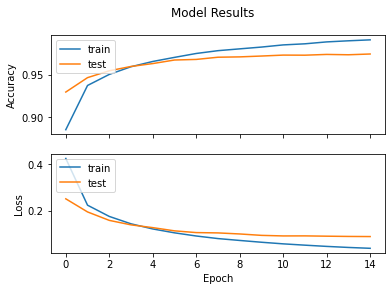

In [15]:
# Visualize results
visualize_training_results(history)

We have two plots above both relating to the quality of our model.  The bottom plot is our loss. It uses the probabilities associated with our predictions to judge how well our prediction fits reality. We want it to decrease as far as possible.

The accuracy judges how well the predictions are after applying the threshold at the output layer.  We want accuracy to increase.

#### Evaluate: 

How'd we do?

- good


Any issues?

- abit overfit 



In [17]:
# We can adjust if we like! Anyone want to add layers, etc?

model = Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Flatten(), # need to flatten our images to be one long array
        layers.Dense(64, activation="tanh"),
        layers.Dense(32, activation="tanh"),
        layers.Dense(16, activation="tanh"),
        layers.Dense(num_classes, activation="softmax"),
    ])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                170       
Total params: 53,018
Trainable params: 53,018
Non-trainable params: 0
_________________________________________________________________


Epoch 1/15
469/469 [==============================] - 1s 2ms/step - loss: 0.5453 - accuracy: 0.8766 - val_loss: 0.2621 - val_accuracy: 0.9345
Epoch 2/15
469/469 [==============================] - 1s 2ms/step - loss: 0.2108 - accuracy: 0.9434 - val_loss: 0.1685 - val_accuracy: 0.9554
Epoch 3/15
469/469 [==============================] - 1s 2ms/step - loss: 0.1450 - accuracy: 0.9604 - val_loss: 0.1320 - val_accuracy: 0.9630
Epoch 4/15
469/469 [==============================] - 1s 2ms/step - loss: 0.1114 - accuracy: 0.9694 - val_loss: 0.1168 - val_accuracy: 0.9666
Epoch 5/15
469/469 [==============================] - 1s 3ms/step - loss: 0.0894 - accuracy: 0.9744 - val_loss: 0.1129 - val_accuracy: 0.9682
Epoch 6/15
469/469 [==============================] - 1s 2ms/step - loss: 0.0752 - accuracy: 0.9787 - val_loss: 0.0993 - val_accuracy: 0.9710
Epoch 7/15
469/469 [==============================] - 1s 3ms/step - loss: 0.0634 - accuracy: 0.9819 - val_loss: 0.1033 - val_accuracy: 0.9685
Epoch 

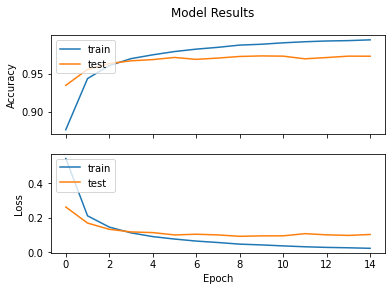

In [18]:
# Compiling our model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Defining our training hyperparameters
# Initial values from: https://keras.io/examples/vision/mnist_convnet/
batch_size = 128
epochs = 15

# Fit our model (save output to a history variable)
history = model.fit(X_train, 
                    y_train, 
                    batch_size=batch_size,
                    epochs=epochs, 
                    validation_data=(X_test, y_test))

# Evaluate!
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

# Visualize results
visualize_training_results(history)

## Regularization

Does regularization make sense in the context of neural networks? <br/>

Yes! We still have all of the salient ingredients: a loss function, overfitting vs. underfitting, and coefficients (weights) that could get too large.

But there are now a few different flavors besides L1 and L2 regularization. (Note that L1 regularization is not common in the context of  neural networks.)

We'll add a few more layers to give regularization a better chance of making a difference!

In [19]:
# Paste your model here
# Then, add kernel_regularizer arguments into the second dense layer!
# Might want to add a fewer smaller layers - lets the reg params have impact
model = Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Flatten(), # need to flatten our images to be one long array
        layers.Dense(64, activation="tanh",
                    kernel_regularizer=l2(0.01)),
        layers.Dense(32, activation="tanh"),
        layers.Dense(16, activation="tanh"),
        layers.Dense(num_classes, activation="softmax"),
    ])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_9 (Dense)              (None, 10)                170       
Total params: 53,018
Trainable params: 53,018
Non-trainable params: 0
_________________________________________________________________


Epoch 1/15
469/469 [==============================] - 1s 2ms/step - loss: 0.1759 - accuracy: 0.9656 - val_loss: 0.1930 - val_accuracy: 0.9624
Epoch 2/15
469/469 [==============================] - 1s 2ms/step - loss: 0.1697 - accuracy: 0.9678 - val_loss: 0.1672 - val_accuracy: 0.9686
Epoch 3/15
469/469 [==============================] - 1s 2ms/step - loss: 0.1740 - accuracy: 0.9663 - val_loss: 0.1767 - val_accuracy: 0.9657
Epoch 4/15
469/469 [==============================] - 1s 2ms/step - loss: 0.1698 - accuracy: 0.9687 - val_loss: 0.1676 - val_accuracy: 0.9692
Epoch 5/15
469/469 [==============================] - 1s 2ms/step - loss: 0.1718 - accuracy: 0.9673 - val_loss: 0.1825 - val_accuracy: 0.9648
Epoch 6/15
469/469 [==============================] - 1s 2ms/step - loss: 0.1715 - accuracy: 0.9672 - val_loss: 0.1675 - val_accuracy: 0.9698
Epoch 7/15
469/469 [==============================] - 1s 3ms/step - loss: 0.1667 - accuracy: 0.9691 - val_loss: 0.1659 - val_accuracy: 0.9700
Epoch 

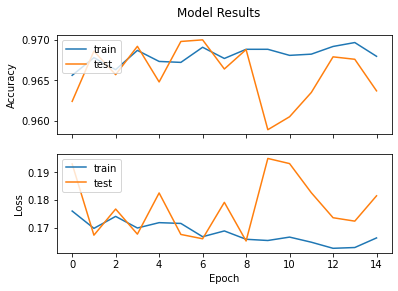

In [23]:
# Compiling our model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Defining our training hyperparameters
# Initial values from: https://keras.io/examples/vision/mnist_convnet/
batch_size = 128
epochs = 15

# Fit our model (save output to a history variable)
history = model.fit(X_train, 
                    y_train, 
                    batch_size=batch_size,
                    epochs=epochs, 
                    validation_data=(X_test, y_test))

# Evaluate!
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

# Visualize results
visualize_training_results(history)

In [ ]:
# Compile your model

In [ ]:
# Fit your model

In [ ]:
# Evaluate

### Dropout

![drop_out](images/drop_out.png)

Dropout is a technique where randomly selected neurons are ignored during training. They are “dropped-out” randomly. This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass and any weight updates are not applied to the neuron on the backward pass. You can add **dropout layers** in your neural network.


<img src='images/thanos.png'/>

### Exercise

To add dropout to a `keras` network, simply add it as though it were a layer. It will apply to the immediately preceding layer.

Useful resource: see how they add in the Dropout layer! https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/

Add Dropout to one or more of your the layers from our base model!

In [28]:
# Paste our base model (without regularization)
# Then add dropout!
model = Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Flatten(), # need to flatten our images to be one long array
        layers.Dense(64, activation="tanh"),
        layers.Dropout(0.1),
        layers.Dense(num_classes, activation="softmax"),
    ])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                50240     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                650       
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Fit
# Compiling our model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Defining our training hyperparameters
# Initial values from: https://keras.io/examples/vision/mnist_convnet/
batch_size = 128
epochs = 15

# Fit our model (save output to a history variable)
history = model.fit(X_train, 
                    y_train, 
                    batch_size=batch_size,
                    epochs=epochs, 
                    validation_data=(X_test, y_test))

Epoch 1/15
469/469 [==============================] - 1s 3ms/step - loss: 0.4543 - accuracy: 0.8759 - val_loss: 0.2588 - val_accuracy: 0.9246
Epoch 2/15
469/469 [==============================] - 1s 2ms/step - loss: 0.2438 - accuracy: 0.9302 - val_loss: 0.1978 - val_accuracy: 0.9417
Epoch 3/15
469/469 [==============================] - 1s 3ms/step - loss: 0.1952 - accuracy: 0.9444 - val_loss: 0.1705 - val_accuracy: 0.9506
Epoch 4/15
469/469 [==============================] - 1s 3ms/step - loss: 0.1667 - accuracy: 0.9518 - val_loss: 0.1482 - val_accuracy: 0.9570
Epoch 5/15
469/469 [==============================] - 1s 2ms/step - loss: 0.1466 - accuracy: 0.9572 - val_loss: 0.1316 - val_accuracy: 0.9600
Epoch 6/15
469/469 [==============================] - 1s 3ms/step - loss: 0.1321 - accuracy: 0.9608 - val_loss: 0.1242 - val_accuracy: 0.9634
Epoch 7/15
469/469 [==============================] - 1s 3ms/step - loss: 0.1194 - accuracy: 0.9650 - val_loss: 0.1170 - val_accuracy: 0.9646
Epoch 

Test loss: 0.09674285352230072
Test accuracy: 0.9706000089645386


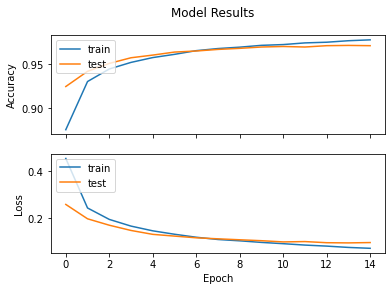

In [30]:
# Evaluate
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

# Visualize results
visualize_training_results(history)

-----

# Convolutional Neural Networks (CNNs)

## Convolutional Layers

A convolutional neural network is a neural network with **convolutional layers**. CNNs are mainly used for image recognition/classification. They can be used for video analysis, NLP (sentiment analysis, topic modeling), and speech recognition. 

### How do our brains see an image? 

We might see some fluffy tail, a wet nose, flappy ears, and a good boy and conclude we are probably seeing a dog. There is not one singular thing about a dog that our brain recognizes as a dog but an amalgamation of different patterns that allow us to make a probable guess.  

<img src='images/chihuahua.jpeg'/>

### How do computers see images?

<img src='images/architecture.jpeg' width=700/>

To computers, color images are a 3D object - composed of 3 matrices - one for each primary color that can be combined in varying intensities to create different colors. Each element in a matrix represents the location of a pixel and contains a number between 0 and 255 which indicates the intensity of the corresponding primary color in that pixel.

<img src='images/rgb_layers.png'/>

## Convolutions

**To *convolve* means to roll together**. CNNs make use of linear algebra to identify patterns using the pixel values (intensity of R,G, or B). By **taking a small matrix and moving it across an image and multiplying them together every time it moves**, our network can mathematically identify patterns in these images. This small matrix is known as a *kernel* or *filter* and each one is designed to identify a particular pattern in an image (edges, shapes, etc.)

<img src='images/convolve.gif' width=500/>

When a filter is "rolled over" an image, the resulting matrix is called a **feature map** - literally a map of where each pattern of feature is in the image. Elements with higher values indicate the presence of a pattern the filter is looking for. The values (or weights) of the filter are adjusted during back-propagation.

#### Convolutional layer parameters

1. Padding: sometimes it is convenient to pad the input volume with zeros around the border. Helps with detecting patterns at the edge of an image
2. Stride: the number of pixels to shift the filter on each "roll". The larger the stride, the smaller the feature map will be - but we will lose more information


### Pooling Layers

After a convolutional layer, the feature maps are fed into a max pool layer. Like convolutions, this method is applied one patch at a time (usually 2x2). Max pooling simply takes the largest value from one patch of an image, places it in a new matrix next to the max values from other patches, and discards the rest of the information contained in the activation maps. Other methods exist such as average pooling (taking an average of the patch).

<img src='images/maxpool.png'/>

This process results in a new feature map with reduced dimensionality that is then passed into another convolution layer to continue the pattern finding process. These steps are repeated until they are passed to a fully connected layer that proceeds to classify the image using the identified patterns.

### Flattening

Once the neural network has collected a series of patterns that an image contains, it is ready to make a guess as to what the image is. In order to do so, it starts by **flattening** the 2D matrix into a 1D vector, so it can be passed into a normal densely connected layer for classification. Then using this vector, one or many densely connected layers will make a prediction as to what the image is.

170500096/170498071 [==============================] - 39s 0us/step
Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


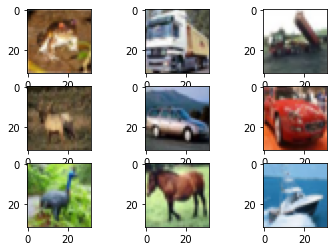

In [31]:
# New dataset!
from keras.datasets import cifar10

# load dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (X_test.shape, y_test.shape))
# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
    
plt.show()
# If you get a "downloading data" thing, worry not, shouldn't take long

In [32]:
# Checking the class balance of our data
import pandas as pd
pd.DataFrame(y_train)[0].value_counts()

9    5000
8    5000
7    5000
6    5000
5    5000
4    5000
3    5000
2    5000
1    5000
0    5000
Name: 0, dtype: int64

In [33]:
# Still need to prep our data
# Scale images to the [0, 1] range
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255
# Make sure images have shape (32, 32, 3)
print("X_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [34]:
# And, prep our outputs
num_classes = 10

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [35]:
# Model building using "add"

cnn = Sequential()
cnn.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
cnn.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
cnn.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
cnn.add(layers.MaxPooling2D((2, 2)))

# now, to get the proper output
cnn.add(layers.Flatten())
cnn.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
cnn.add(layers.Dense(10, activation='softmax'))

cnn.compile(loss='categorical_crossentropy',
            optimizer="adam",
            metrics=['accuracy'])

In [36]:
history = cnn.fit(X_train,
                  y_train,
                  epochs=5, # small since this is just a demo
                  batch_size=64,
                  validation_data=(X_test, y_test))
# note - even with just 5 epochs this'll take at least 2.5 minutes

Epoch 1/5
782/782 [==============================] - 132s 169ms/step - loss: 1.4851 - accuracy: 0.4540 - val_loss: 1.0930 - val_accuracy: 0.6072
Epoch 2/5
782/782 [==============================] - 156s 200ms/step - loss: 0.9584 - accuracy: 0.6596 - val_loss: 0.8881 - val_accuracy: 0.6874
Epoch 3/5
782/782 [==============================] - 153s 195ms/step - loss: 0.7656 - accuracy: 0.7307 - val_loss: 0.7628 - val_accuracy: 0.7409
Epoch 4/5
782/782 [==============================] - 144s 184ms/step - loss: 0.6315 - accuracy: 0.7770 - val_loss: 0.7393 - val_accuracy: 0.7454
Epoch 5/5
782/782 [==============================] - 142s 181ms/step - loss: 0.5300 - accuracy: 0.8158 - val_loss: 0.7600 - val_accuracy: 0.7464


Test loss: 0.7600154280662537
Test accuracy: 0.746399998664856


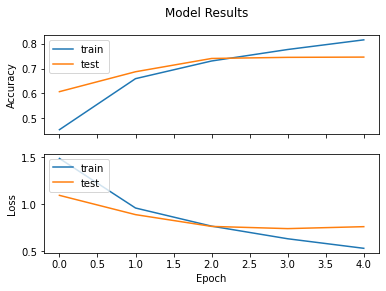

In [37]:
# Evaluate!
score = cnn.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

# Visualize results
visualize_training_results(history)

A worked-through example on this dataset: https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/